# **visualize the optimized actions**

In [1]:
import functools
import torch
# from src.models.expert.classfier_cell_state import CellStateClassifier, torch_to_jax
from src.techinical_noise import AddTechnicalNoise
from copy import deepcopy
from time import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

from src.load_utils import load_grn_jax, topo_sort_graph_layers, get_basal_production_rate
from src.zoo_functions import is_debugger_active, plot_three_genes, open_datasets_json, dataset_namedtuple
from jax_simulator import Sim

import numpy as np
from src.techinical_noise import AddTechnicalNoise
from sklearn.decomposition import PCA     
from sklearn.manifold import TSNE    
import matplotlib.pyplot as plt
import scanpy as sc
import sc3s
from umap import UMAP

simulation num step per trajectories:  10000
(10000, 100, 3)
time: 7.885977506637573


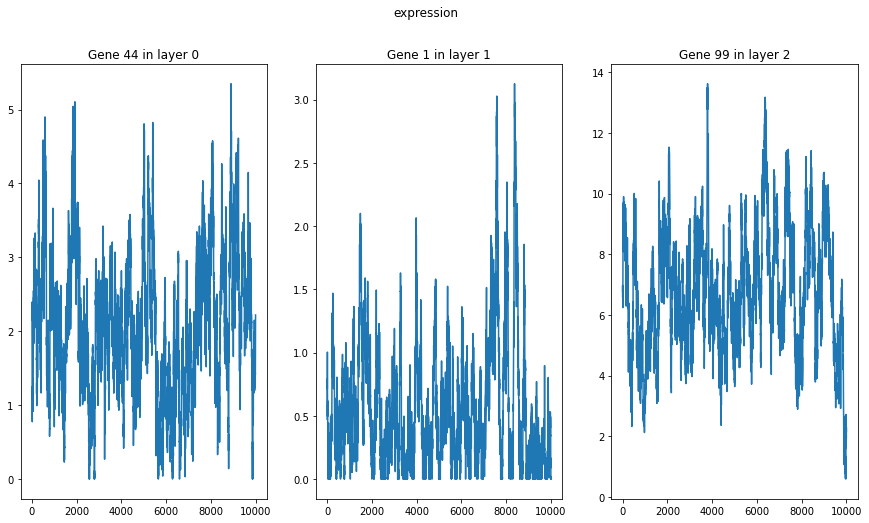

shape noisy data: (100, 30000)


In [2]:
start = time()
simulation_num_steps = 10000
dataset_dict = open_datasets_json(return_specific_dataset='DS4')
dataset = dataset_namedtuple(*dataset_dict.values())
sim = Sim(num_genes=dataset.tot_genes, num_cells_types=dataset.tot_cell_types,
          interactions_filepath=dataset.interactions,
          regulators_filepath=dataset.regulators,
          simulation_num_steps=simulation_num_steps,
          noise_amplitude=0.8,
          )
sim.build()

actions = jnp.array(np.load("data/actions_ds4.npy"))
x = sim.run_one_rollout(actions)

expr_clean = jnp.stack(tuple([x[gene] for gene in range(sim.num_genes)])).swapaxes(0, 1)

print(expr_clean.shape)
print(f"time: {time() - start}")
plot_three_genes(expr_clean.T[0, 44], expr_clean.T[0, 1], expr_clean.T[0, 99], hlines=None, title="expression")

expr = AddTechnicalNoise(dataset.tot_genes, dataset.tot_cell_types, simulation_num_steps,
                         dataset.params_outliers_genes_noise,
                         dataset.params_library_size_noise,
                         dataset.params_dropout_noise).get_noisy_technical_concentration(expr_clean.T)
print(f"shape noisy data: {expr.shape}")


In [9]:
expr_clean.shape

(10000, 100, 3)

In [5]:
expr = expr.T

In [10]:
expr = jnp.concatenate(expr_clean, axis=1).T

(30000, 100)


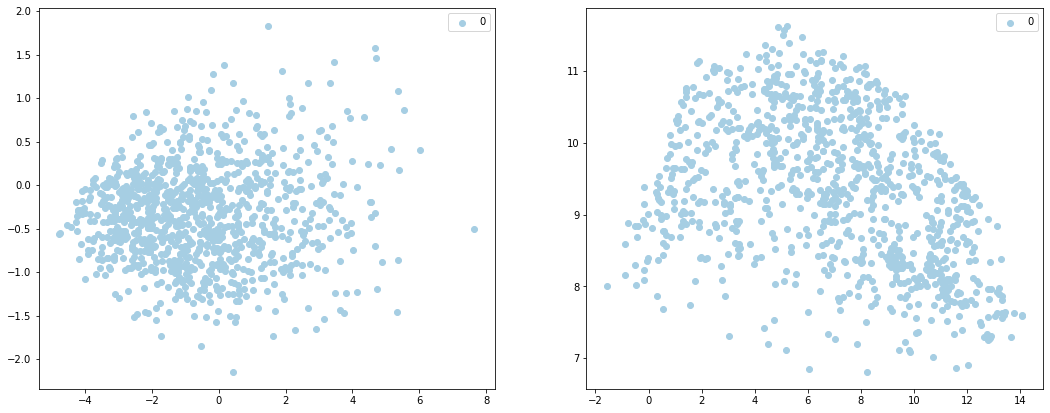

In [6]:
def plot_labelled_dimentionality_reduction(xy, num_cell_types, num_sim_cells, ax=None):
    anno = np.concatenate([np.array([str(x)] * num_sim_cells, dtype=object) for x in range(1)], axis=0)
    if ax is None:
        fig = plt.figure(figsize = (10, 7))
        ax = fig.add_subplot()
    colormap = plt.get_cmap("Paired")
    for i, clust in enumerate(np.sort(np.unique(anno))):
        idx = np.where(anno == clust)[0]
        ax.scatter(xy[idx, 0], xy[idx, 1], color = colormap(i), label = clust)
    ax.legend()
    
num_cell_types=3
NUM_SIM_CELLS = 1000

counts = expr/(np.sum(expr, axis = 1)[:, None] + 1e-6)* 100
counts = np.log1p(expr)

print(counts.shape)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18, 7))
x_pca = pca = PCA(n_components = 10).fit_transform(counts)
plot_labelled_dimentionality_reduction(x_pca, num_cell_types, NUM_SIM_CELLS, ax[0])

xy_umap = UMAP(n_components = 2).fit_transform(x_pca)
plot_labelled_dimentionality_reduction(xy_umap, num_cell_types, NUM_SIM_CELLS, ax[1])